<a href="https://colab.research.google.com/github/PSLeon24/Artificial_Intelligence/blob/main/RNN_Netflix_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/netflix_stock_data.csv")
data.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


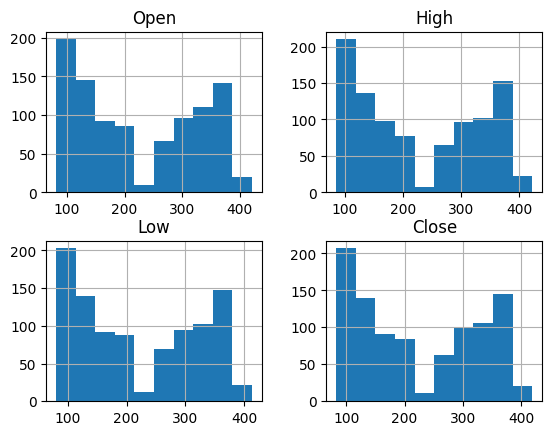

In [3]:
import matplotlib.pyplot as plt

data_used = data.iloc[:, 1:4] # open, high, low
data_used['Close']  = data['Close']
hist = data_used.hist()
plt.show()

In [5]:
import numpy as np

from torch.utils.data.dataset import Dataset

class Netflix(Dataset):
  def __init__(self):
    self.csv = pd.read_csv("/content/drive/MyDrive/netflix_stock_data.csv")

    self.data = self.csv.iloc[:, 1:4].values
    self.data = self.data / np.max(self.data) # normalize between 0 and 1

    self.label = data['Close'].values
    self.label = self.label / np.max(self.label)

  def __len__(self):
    return len(self.data) - 30

  def __getitem__(self, i):
    data = self.data[i:i+30]
    label = self.label[i+30]

    return data, label

In [7]:
import torch
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self):
    super(RNN, self).__init__()

    self.rnn = nn.RNN(input_size = 3, hidden_size = 8, num_layers = 5,
                      batch_first = True)

    self.fc1 = nn.Linear(in_features = 240, out_features = 64)
    self.fc2 = nn.Linear(in_features = 64, out_features = 1)

    self.relu = nn.ReLU()

  def forward(self, x, h0):
    x, hn = self.rnn(x, h0) # output of RNN layer

    x = torch.reshape(x, (x.shape[0], -1))

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    x = torch.flatten(x)

    return x

In [9]:
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)
dataset = Netflix()

In [10]:
loader = DataLoader(dataset, batch_size = 32)

In [11]:
optim = Adam(params = model.parameters(), lr = 0.0001)

In [12]:
for epoch in range(200):
  iterator = tqdm.tqdm(loader)
  for data, label in iterator:
    optim.zero_grad()

    h0 = torch.zeros(5, data.shape[0], 8).to(device)

    pred = model(data.type(torch.FloatTensor).to(device), h0)

    loss = nn.MSELoss()(pred,
                        label.type(torch.FloatTensor).to(device))
    loss.backward()
    optim.step()

    iterator.set_description(f"epoch {epoch}, loss: {loss.item()}")

torch.save(model.state_dict(), "./rnn.pth")

epoch 199, loss: 0.0006481044110842049: 100%|██████████| 30/30 [00:00<00:00, 129.06it/s]


In [13]:
loader = DataLoader(dataset, batch_size = 1)

preds = []
total_loss = 0

with torch.no_grad():
  model.load_state_dict(torch.load("rnn.pth", map_location = device))

  for data, label in loader:
    h0 = torch.zeros(5, data.shape[0], 8).to(device)

    pred = model(data.type(torch.FloatTensor).to(device), h0)
    preds.append(pred.item())

    loss = nn.MSELoss()(pred,
                        label.type(torch.FloatTensor).to(device))

    total_loss += loss / len(loader)

In [14]:
total_loss.item()

0.0017586634494364262

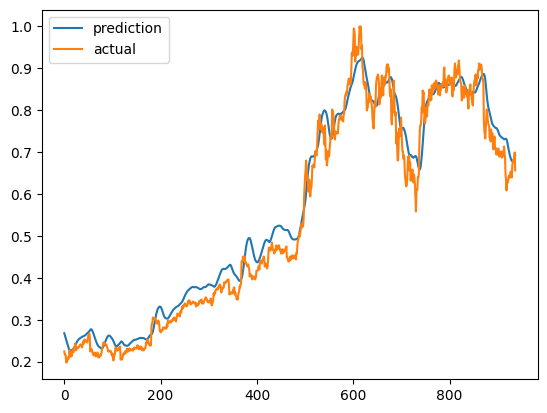

In [15]:
plt.plot(preds, label = "prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()